In [1]:
# stdlib imports
from datetime import datetime
import os
import re
import warnings
import sys
import glob
import math
import scipy.constants as sp
import pandas as pd

from obspy.core.trace import Trace
from obspy.core.stream import Stream
from obspy.core.trace import Stats
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import processing
import arias_intensity
import CAV
from amptools.io.knet.core import read_knet
from amptools.stream import group_channels
from obspy import UTCDateTime
from libcomcat.search import get_event_by_id
from obspy.geodetics import gps2dist_azimuth, kilometers2degrees
from obspy.taup import TauPyModel
from obspy import read
from matplotlib.dates import date2num
from matplotlib.pyplot import close
from collections import OrderedDict
warnings.filterwarnings('ignore')

Northridge Earthquake

In [2]:
data_dir = '/Users/tnye/PROJECTS/Duration/data/ci3144585/ground_motion'
file_names = ['1994.c.017m30su.n0a',
              '1994.c.017m30su.n0b',
              '1994.c.017m30su.n0c']
files = [os.path.join(data_dir, f) for f in file_names]
stream = Stream()

for i in range(len(files)):
    cmp = processing.read_data(files[i], units='acc')[0]
    stream.append(cmp)
    
for i, trace in enumerate(stream):
    trace_stats = trace.stats
    channel = trace.stats['channel']
    dt = trace_stats.delta

acc = trace.data

In [3]:
os.chdir('/Users/tnye/PROJECTS/Duration/data/ci3144585/ground_motion')
types = ('*.n0a', '*.n0b', '*.n0c')
station = []
for files in types:
    station.extend(glob.glob(files))

stream = Stream()

for i in range(len(station)):
    cmp = processing.read_data(station[i], units='acc')[0]
    stream.append(cmp)

Read Knet Data

In [4]:
stream = Stream()
trace = Trace()

from obspy import read 

os.chdir("/Users/tnye/PROJECTS/Duration/data/usp000g9h6/ground_motion/knt")
types = ('*.EW', '*.NS', '*.UD')
files_grabbed = []
for files in types:
    files_grabbed.extend(glob.glob(files))

data = []
for i in range(len(files_grabbed)):
    data.append(read(files_grabbed[i]))
    
names = pd.read_csv('/Users/tnye/PROJECTS/Duration/data/usp000g9h6/ground_motion/knt/knt2008.csv')
names_list = names.to_string(index = False)
filtered_files = []
for st in data:
    for i in range(len(st)):
        trace = st[i]
        if trace.stats.station in names_list:
            filtered_files.append([trace])

stations = group_channels(filtered_files)

for sta in stations:
    sta.detrend('demean')

# Add calibration to get data into gals (sm/s^2)
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        trace.data = trace.data * trace.stats.calib * 100

# Set calibration to 1 to avoid double calibration when plotting.
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        trace.stats.calib = 1

In [5]:
station_stats = []
for i in range(len(stations)):
    station = stations[i]
    trace = station[0]
    name = trace.stats['station']
    stat_lat = trace.stats['knet']['stla']
    stat_lon = trace.stats['knet']['stlo']
    elev = trace.stats['knet']['evlo']
    station_stats.append([name, stat_lat, stat_lon, elev])

Get Earthquake Data

In [6]:
event_id = 'usp000g9h6'
detail = get_event_by_id(event_id)
date = UTCDateTime(detail.time)
mag = detail.magnitude
source_lat = detail.latitude
source_lon = detail.longitude
depth = detail.depth

# Add event stats to each trace in each station
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        eventID = event_id
        magnitude = mag
        source_depth = depth
        event_lat = source_lat
        event_lon = source_lon
        
        trace.stats.eventID = eventID
        trace.stats.mag = magnitude
        trace.stats.source_depth = source_depth
        trace.stats.source_lat = event_lat
        trace.stats.source_lon = event_lon

Add Distance and P-arrivals to trace stats

In [7]:
model = TauPyModel(model="iasp91")
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        
        # Compute distance
        dist_az_baz = gps2dist_azimuth(
            trace.stats['knet']['stla'],
            trace.stats['knet']['stlo'],
            trace.stats['knet']['evla'], 
            trace.stats['knet']['evlo'])
        distance_meters = dist_az_baz[0]
        distance_km = distance_meters/1000.0
        dd = kilometers2degrees(distance_km)
        #trace.stats.distance = distance_meters
        trace.stats.rdist = distance_km
        
        # Estimated travel time for p wave
        p = model.get_travel_times(depth, dd, phase_list=['p', 'P'])
        trace.stats.P_arriv = p[0].time

In [8]:
hcomp = Stream()
for sta in stations:
    newtrace = sta.select(channel='NS')
    hcomp += newtrace

sorted_hcomp = hcomp.sort(keys=['rdist'])

Plot PGA vs distance from Source

In [9]:
max_acc = []
dist_source = []
for trace in sorted_hcomp:
    amax = trace.stats.knet.accmax
    dist = trace.stats.rdist
    max_acc.append(amax)
    dist_source.append(dist)

PGA = np.array(max_acc)
DIST = np.array(dist_source)

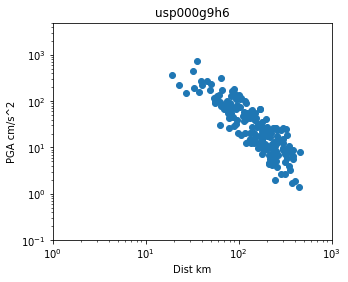

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
plt.scatter(DIST, PGA)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('PGA cm/s^2')
plt.xlabel('Dist km')
plt.title('usp000g9h6')
ax.set_xlim(1,1000)
ax.set_ylim(0.1,5000)
plt.show()
plt.savefig('/Users/tnye/PROJECTS/Duration/data/usp000g9h6/figures/PGA_dist.png', dpi=300)

Get Ia and CAV for knet files

In [11]:
dt = 0.01
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        starttime = trace.stats.P_arriv
        acc = np.multiply(0.01, trace.data)
        Ia, NIa, = arias_intensity.get_arias_intensity(acc, 0.01, 0)
        newIa, newNIa = arias_intensity.get_arias_intensity(acc, 0.01, starttime)

        trace.stats.Ia = Ia
        trace.stats.NIa = NIa
        trace.stats.maxIa = np.amax(Ia)
        trace.stats.PIa = newIa
        trace.stats.PNIa = newNIa
        trace.stats.maxPIa = np.amax(newIa)
        
        time1 = arias_intensity.get_time_from_percent(NIa, 0.05, dt)
        time2 = arias_intensity.get_time_from_percent(NIa, 0.95, dt)
        trace.stats.arias5 = time1
        trace.stats.arias95 = time2    


ValueError: zero-size array to reduction operation maximum which has no identity

In [24]:
trace = stations[0][0]
starttime = trace.stats.P_arriv
g = sp.g
npts = len(trace.data)
t = np.linspace(0, (npts-1)*dt, num=npts)
acc = np.multiply(trace.data, 0.01)
    
# Choose acceleration values starting at the specificed starttime
acc2 = acc[t >= starttime]
    
# Calculate Arias intensity 
Int = integrate.cumtrapz(acc2*acc2, dx=dt)
Ia = Int * np.pi/(2*g)

# Calculate normalized Arias intensity
# divide arias intensity by its max value
NIa = Ia/np.amax(Ia)

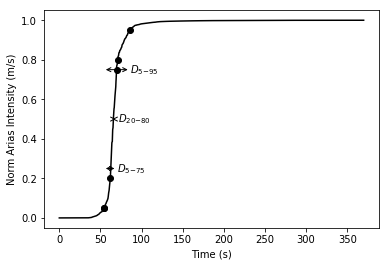

In [17]:
NIa = stations[10][0].stats.NIa
npts = len(NIa)
t = np.linspace(0, (npts-1)*dt, num=npts)
durations = [(0.05, 0.75),
             (0.2, 0.8),
             (0.05, .95)]
f, axes = plt.subplots(1, 1, sharex=True)
arias_intensity.plot_durations(NIa, dt, durations, axes, xlab=True)

In [18]:
#maxIa = []
maxPIa = []
duration = []
ratio = []
for trace in sorted_hcomp:
    #arias = trace.stats.maxIa
    #Parias = trace.stats.maxPIa
    #dur = (trace.stats.arias95 - trace.stats.arias5)
    Aratio = (Parias / arias)
    #maxIa.append(arias)
    maxPIa.append(Parias)
    duration.append(dur)
    ratio.append(Aratio)

#arias = np.array(maxIa)
#Parias = np.array(maxPIa)
durations = np.array(duration)
ratios = np.array(ratio)

In [ ]:
for sta in stations:
    for i in range(len(sta)):
        trace = sta[i]
        CAVacc = trace.data
        cav, cav5, cavstd = CAV.get_CAV(CAVacc, trace.stats['delta'], 0)
        trace.stats.CAV = cav
        trace.stats.CAV5 = cav5
        trace.stats.CAVstd = cavstd

Arias Intensity with P-arrivals

NameError: name 'arias' is not defined

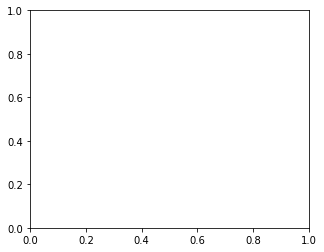

In [12]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
plt.scatter(DIST, arias, s=20, c='b', label='Unfiltered Arias')
plt.scatter(DIST, Parias, s=10, c='g', label='Filtered Arias')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Arias Intensity')
plt.xlabel('Dist km')
plt.title('usp000g9h6')
ax.set_xlim(1,500)
ax.set_ylim(0.1,5)
plt.legend(loc='upper left')
plt.show()
plt.savefig('/Users/tnye/PROJECTS/Duration/data/usp000g9h6/figures/arias.png', dpi=300)

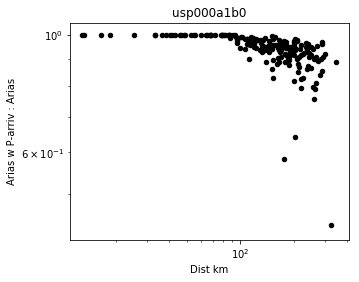

<Figure size 432x288 with 0 Axes>

In [27]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
plt.scatter(DIST, ratios, s=20, c='k')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Arias w P-arriv : Arias')
plt.xlabel('Dist km')
plt.title('usp000a1b0')
plt.show()
plt.savefig('/Users/tnye/PROJECTS/Duration/data/usp000a1b0/figures/Arias_ratio.png', dpi=300)

In [ ]:
#print(Stream.__str__(sorted_stz, extended=True))